# Plan Cache Exploration
This notebook demonstrates QuASAr's plan cache when executing a parameterized circuit multiple times. It records cache hit rates, cumulative speedup from warm vs cold cache runs, and reuse within the conversion engine.

In [1]:
import time
import tracemalloc
import inspect
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
import quasar
import quasar_convert as qconv
from quasar.planner import Planner

In [2]:
def build_circuit(theta1, theta2):
    qc = QuantumCircuit(2)
    qc.rx(theta1, 0)
    qc.cx(0, 1)
    qc.ry(theta2, 1)
    return quasar.Circuit.from_qiskit(qc)

In [3]:

angles = [(0.1,0.2), (0.3,0.4), (0.5,0.6)] * 3
planner_kwargs = {'quick_max_qubits': 0}
if 'compare_pre_pass_costs' in inspect.signature(Planner).parameters:
    planner_kwargs['compare_pre_pass_costs'] = True
planner_cold = Planner(**planner_kwargs)
planner_warm = Planner(**planner_kwargs)
engine = qconv.ConversionEngine()
metrics = []

def time_and_peak_memory(planner, circ, *, use_cache):
    tracemalloc.start()
    t0 = time.time()
    planner.plan(circ, use_cache=use_cache)
    runtime = time.time() - t0
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return runtime, peak / 1e6  # MB

for idx, (a,b) in enumerate(angles, start=1):
    circ = build_circuit(a,b)
    engine.extract_ssd([0,1], 2)
    cold_time, cold_mem = time_and_peak_memory(planner_cold, circ, use_cache=False)
    warm_time, warm_mem = time_and_peak_memory(planner_warm, circ, use_cache=True)
    metrics.append({'run': idx,
                    'cache_hits': planner_warm.cache_hits,
                    'hit_rate': planner_warm.cache_hits/idx,
                    'conversion_reuse': idx - len(getattr(engine, 'ssd_cache', getattr(engine, '_ssd_cache', {}))),
                    'cold_time': cold_time,
                    'warm_time': warm_time,
                    'cold_memory': cold_mem,
                    'warm_memory': warm_mem})

import pandas as pd

df = pd.DataFrame(metrics)
df['cum_cold_time'] = df['cold_time'].cumsum()
df['cum_warm_time'] = df['warm_time'].cumsum()
df['cum_cold_memory'] = df['cold_memory'].cumsum()
df['cum_warm_memory'] = df['warm_memory'].cumsum()
df['cumulative_speedup'] = df['cum_cold_time']/df['cum_warm_time']
df['cumulative_memory_savings'] = df['cum_cold_memory']/df['cum_warm_memory']
df[['run','hit_rate','conversion_reuse','cumulative_speedup','cumulative_memory_savings']]



,run,hit_rate,conversion_reuse,cumulative_speedup,cumulative_memory_savings
0,1,0.000000,0,1.101736,1.321302
1,2,0.000000,1,1.061847,1.188641
2,3,0.000000,2,1.025350,1.142080
3,4,0.250000,3,1.323846,1.374162
4,5,0.400000,4,1.612557,1.560961
5,6,0.500000,5,1.893731,1.725612
6,7,0.571429,6,2.187043,1.872431
7,8,0.625000,7,2.466748,2.003761
8,9,0.666667,8,2.729457,2.124277


In [4]:
df[['run','hit_rate','conversion_reuse','cumulative_speedup','cumulative_memory_savings']]


,run,hit_rate,conversion_reuse,cumulative_speedup,cumulative_memory_savings
0,1,0.000000,0,1.101736,1.321302
1,2,0.000000,1,1.061847,1.188641
2,3,0.000000,2,1.025350,1.142080
3,4,0.250000,3,1.323846,1.374162
4,5,0.400000,4,1.612557,1.560961
5,6,0.500000,5,1.893731,1.725612
6,7,0.571429,6,2.187043,1.872431
7,8,0.625000,7,2.466748,2.003761
8,9,0.666667,8,2.729457,2.124277


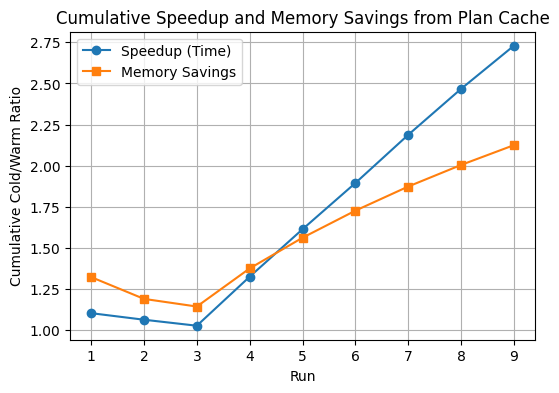

In [5]:

plt.figure(figsize=(6,4))
plt.plot(df['run'], df['cumulative_speedup'], marker='o', label='Speedup (Time)')
plt.plot(df['run'], df['cumulative_memory_savings'], marker='s', label='Memory Savings')
plt.xlabel('Run')
plt.ylabel('Cumulative Cold/Warm Ratio')
plt.title('Cumulative Speedup and Memory Savings from Plan Cache')
plt.grid(True)
plt.legend()
plt.show()


In [6]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [7]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = '06_plan_cache'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))



{
  "In": [
    "",
    "import time\nimport tracemalloc\nimport inspect\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom qiskit import QuantumCircuit\nimport quasar\nimport quasar_convert as qconv\nfrom quasar.planner import Planner",
    "def build_circuit(theta1, theta2):\n    qc = QuantumCircuit(2)\n    qc.rx(theta1, 0)\n    qc.cx(0, 1)\n    qc.ry(theta2, 1)\n    return quasar.Circuit.from_qiskit(qc)",
    "angles = [(0.1,0.2), (0.3,0.4), (0.5,0.6)] * 3\nplanner_kwargs = {'quick_max_qubits': 0}\nif 'compare_pre_pass_costs' in inspect.signature(Planner).parameters:\n    planner_kwargs['compare_pre_pass_costs'] = True\nplanner_cold = Planner(**planner_kwargs)\nplanner_warm = Planner(**planner_kwargs)\nengine = qconv.ConversionEngine()\nmetrics = []\n\ndef time_and_peak_memory(planner, circ, *, use_cache):\n    tracemalloc.start()\n    t0 = time.time()\n    planner.plan(circ, use_cache=use_cache)\n    runtime = time.time() - t0\n    _, peak = tracemalloc.get_traced_memory()